In [3]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import random
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

In [31]:
class BW_comp(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('units', 300),
        ('p_stake', 100),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('wave_period_buy', 7),
        ('wave_period_sell', 7),

        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )

    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))

    
    def __init__(self):

        # Record ATR Initial
        self.atr_initial = self.broker.get_cash()
        self.inds = dict()
        self.profit_i = dict()
        self.data_tracker = None
        self.money_unit = self.broker.get_cash() / self.params.units

        for d in self.datas:

            self.inds[d] = dict()
            self.profit_i[d._name] = 0

            # Keep references to lines in the data[0] dataseries
            self.inds[d]['dataclose'] = d.close
            self.inds[d]['datahigh'] = d.high
            self.inds[d]['datalow'] = d.low

            # Keep references to executed order & price
            self.inds[d]['buyprice'] = 0
            self.inds[d]['sellprice'] = 0
            self.inds[d]['order'] = None

            # Add indicators
            ## Bollinger Bands indicator
            self.inds[d]['bolling'] = bt.indicators.BollingerBands(d, 
                                                        period=self.params.bollinger_per, 
                                                        devfactor=self.params.bollinger_dev)
            self.inds[d]['direction'] = bt.And(self.inds[d]['dataclose'](0) < self.inds[d]['dataclose'](-1),
                                                                      self.inds[d]['dataclose'](-1) < self.inds[d]['dataclose'](-2),
                                                                      self.inds[d]['dataclose'](-2) < self.inds[d]['dataclose'](-3))
            #self.inds[d]['bolling_buy'] = bt.Or(bt.And(self.inds[d]['dataclose'](0) > self.inds[d]['bolling'].top(0), 
            #                                           self.inds[d]['dataclose'](-1) < self.inds[d]['bolling'].top(-1)), 
            #                                    bt.And(self.inds[d]['dataclose'](0) > self.inds[d]['bolling'].bot(0), 
            #                                           self.inds[d]['dataclose'](-1) < self.inds[d]['bolling'].bot(-1)))
            self.inds[d]['bolling_buy'] = bt.And(self.inds[d]['dataclose'](0) > self.inds[d]['bolling'].mid(0), 
                                                 self.inds[d]['dataclose'](-1) < self.inds[d]['bolling'].mid(-1))

            self.inds[d]['bolling_sell'] = bt.Or(bt.And(self.inds[d]['dataclose'](0) < self.inds[d]['bolling'].top(0), 
                                                        self.inds[d]['dataclose'](-1) > self.inds[d]['bolling'].top(-1)), 
                                                 bt.And(self.inds[d]['dataclose'](0) < self.inds[d]['bolling'].bot(0), 
                                                        self.inds[d]['dataclose'](-1) > self.inds[d]['bolling'].bot(-1)))


            ## MovingAverageSimple indicator
            self.inds[d]['sma_buy'] = bt.indicators.SimpleMovingAverage(d, period=self.params.wave_period_buy)
            self.inds[d]['sma_sell'] = bt.indicators.SimpleMovingAverage(d, period=self.params.wave_period_sell)
            
            ## Wave indicator
            self.inds[d]['wave_buy'] = bt.And(self.inds[d]['sma_buy'](0) > self.inds[d]['sma_buy'](-1), 
                                              self.inds[d]['sma_buy'](-1) < self.inds[d]['sma_buy'](-2), 
                                              self.inds[d]['sma_buy'](-2) < self.inds[d]['sma_buy'](-3),
                                              self.inds[d]['sma_buy'](0) > self.inds[d]['bolling'].mid(0))
                                             

            self.inds[d]['wave_sell'] = bt.And(self.inds[d]['sma_sell'](0) < self.inds[d]['sma_sell'](-1), 
                                               self.inds[d]['sma_sell'](-1) > self.inds[d]['sma_sell'](-2), 
                                               self.inds[d]['sma_sell'](-2) > self.inds[d]['sma_sell'](-3))
        
            ## ATR indicator
            self.inds[d]['tr'] = bt.indicators.Max((self.inds[d]['datahigh'](0) - self.inds[d]['datalow'](0)), 
                                                    abs(self.inds[d]['dataclose'](-1) - self.inds[d]['datahigh'](0)),
                                                    abs(self.inds[d]['dataclose'](-1) - self.inds[d]['datalow'](0)))
            self.inds[d]['atr'] = bt.indicators.SimpleMovingAverage(self.inds[d]['tr'], period=self.params.atr_period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                if self.inds[self.data_tracker]['wave_buy']:
                    self.inds[self.data_tracker]['buyprice']
                self.log('买单执行, 代码：%s, 价格:%.2f, 股数:%i, 持有现金:%i' %
                         (order.info['name'],
                          order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))
                self.profit_i[order.info['name']] -= order.executed.price*order.executed.size

            else:  # Sell
                self.inds[self.data_tracker]['sellprice'] = order.executed.price
                self.log('卖单执行, 代码：%s, 价格:%.2f, 股数:%i, 持有现金:%i' %
                        (order.info['name'],
                         order.executed.price,
                         -order.executed.size,
                         self.broker.get_cash()))
                self.profit_i[order.info['name']] -= order.executed.price*order.executed.size

        elif order.status in [order.Canceled]:
            self.log('订单取消：被撤销')

        elif order.status in [order.Margin]:
            self.log('订单取消：资金不足，代码：%s，持有资金:%i' %
                        (order.info['name'],
                         self.broker.get_cash()))

        elif order.status in [order.Rejected]:
            self.log('订单取消：被拒绝')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('交易收益：代码：%s, 毛利润 %.2f, 净利润 %.2f' %
                 (trade.history[0]['event']['order'].info['name'], 
                  trade.pnl, trade.pnlcomm))
        
        self.money_unit = self.broker.get_cash() / self.params.units
        

    def next(self):

        buy_list = []
        sell_list = []

        for d in self.datas:
        # Check if an order is pending ... if yes, we cannot send a 2nd one
            if self.inds[d]['order']:
                return

            #buy_indicator = (self.inds[d]['wave_buy'] and self.inds[d]['dataclose'][0] > self.inds[d]['bolling'].mid[0]) or  self.inds[d]['bolling_buy']
            buy_indicator = self.inds[d]['wave_buy'] and self.inds[d]['sma_buy'][0] > self.inds[d]['bolling'].mid[0]
            sell_indicator = self.inds[d]['wave_sell'] or self.inds[d]['bolling_sell']

            if sell_indicator and self.getposition(d).size > 0:
                sell_list.append((d, -1))

            elif buy_indicator and self.getposition(d).size == 0 and not self.inds[d]['direction']:
                if self.params.using_atr:
                    opt_pos = np.floor(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.inds[d]['atr'][0])
                    if opt_pos*self.params.p_stake > 0 and self.getposition(d).size < opt_pos*self.params.p_stake:
                        buy_list.append((d, 
                                        opt_pos*self.params.p_stake-self.getposition(d).size, 
                                        (opt_pos*self.params.p_stake-self.getposition(d).size)*self.inds[d]['dataclose'][0]))
                else:
                    lots = np.floor(self.money_unit / (self.params.p_stake*self.inds[d]['dataclose'][0]))*self.params.p_stake
                    buy_list.append((d, lots, lots * self.inds[d]['dataclose'][0]))
        
        for s_order in sell_list:
            self.data_tracker = s_order[0]
            self.log('卖单创建, 代码: %s, 价格: %.2f, 股数:%i, 现有持仓: %i' % 
                        (s_order[0]._name, 
                        self.inds[s_order[0]]['dataclose'][0],
                        s_order[1] if s_order[1] != -1 else self.getposition(s_order[0]).size,
                        self.getposition(s_order[0]).size))
            self.sell(data=s_order[0], 
                        size=s_order[1] if s_order[1] != -1 else self.getposition(s_order[0]).size, 
                        name=s_order[0]._name)
        
        #buy_list = sorted(buy_list, key=lambda x: x[2], reverse=False)
        random.shuffle(buy_list)
        for b_order in buy_list:
            self.data_tracker = b_order[0]
            self.log('买单创建, 代码: %s, 价格: %.2f, 股数: %i, 现有持仓: %i' % 
                        (b_order[0]._name, 
                        self.inds[b_order[0]]['dataclose'][0], 
                        b_order[1],
                        self.getposition(b_order[0]).size))
            self.buy(data=b_order[0], size=b_order[1], name=b_order[0]._name)


    def stop(self):
        #for d in self.datas:
        #    if self.getposition(d).size > 0:
        #        self.profit_i[d._name] += self.getposition(d).size * d.close[0]
        #self.log('Ending Value:%.2f.' %
        #        (self.cerebro.broker.getvalue()), doprint=False)
        #print(sorted(self.profit_i.items(), key=lambda x: x[1]))
        #print(sum([x[1] for x in self.profit_i.items()]))
        return

# 全市场回测

### 数据下载

In [8]:
s_date = datetime.date(2020, 12, 31) - datetime.timedelta(days = 365 * 2)
e_date = datetime.date(2020, 12, 31)

#s_date = datetime.datetime.now() - datetime.timedelta(days = 365)
#e_date = datetime.datetime.now()

stock_index = '399300.SZ'

# Download Data
utilsJ.index_to_csv_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6',
                            stock_index, 0.2, s_date, e_date, fpath='.\\Data\\2019\\')

### 循环回测

In [ ]:
profit_dict = {}

# 904ff4752522814dca00e032a709fdfc26d8744913500ef204e02157
# 74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6

def getdata_mul(s_code, start=datetime.date(2020, 12, 31)-datetime.timedelta(days = 385),
                end = datetime.date(2020, 12, 31)):
    global cerebro
    df = pd.read_csv('.\\Data\\2019\\'+s_code+'.csv', 
                     converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df, fromdate=s_date, todate=e_date)
    cerebro.adddata(data, name=s_code)
    return

s_date = datetime.date(2020, 12, 31) - datetime.timedelta(days = 385)
e_date = datetime.date(2020, 12, 31)



stock_index = '399300.SZ'
pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=stock_index,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()


if __name__ == '__main__':
    for i in range(10):
        random.seed(10086)
        # Create a cerebro entity
        cerebro = bt.Cerebro(tradehistory=True)

        # Add a strategy
        strats = cerebro.addstrategy(BW_comp, printlog=False, using_atr=True, atr_percent=0.01)

        t_list = [utilsJ.MyThread(getdata_mul, (s_code, s_date, e_date)) for s_code in index_list]
        [t.start() for t in t_list]
        [t.join() for t in t_list]
        #for s_code in index_list:
        #    df = pd.read_csv('.\\Data\\2020\\'+s_code+'.csv', 
        #                     converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
        #    data = bt.feeds.PandasData(dataname=df, fromdate=s_date, todate=e_date)

            # Add the index Data Feed to Cerebo
        #    cerebro.adddata(data, name=s_code)
        
        # Set cash inside the strategy
        cerebro.broker = bt.brokers.BackBroker(coc=True)   
        cerebro.broker.setcash(10000000)

        # Set commission
        #cerebro.broker.setcommission()

        # Print out the starting conditions
        start_value = cerebro.broker.getvalue()
        #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Run over everything
        cerebro.run(maxcpus=8)

        # Print out the final result
        final_value = cerebro.broker.getvalue()
        #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        #print('(%s, %s) Net Profit: %.2f%%' % (s[0], s[1], (final_value - start_value) / start_value * 100))
        print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

### 单次验证

In [ ]:
date_idx = pd.read_csv('.\\Data\\2019\\000001.SZ.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).trade_date
df = pd.read_csv('.\\Data\\2019\\600918.SH.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
df_new = pd.DataFrame([[x,0,0,0,0,0,0] for x in date_idx if x not in df.index], columns=['trade_date', 'open', 'high', 'low', 'close', 'volume', 'openinterest'])
df_new.set_index('trade_date', inplace=True)
pd.concat([df_new, df])

In [50]:
date_idx = pd.read_csv('.\\Data\\2019\\000001.SZ.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).trade_date

if __name__ ==  '__main__':
    
    # Create a cerebro entity
    cerebro = bt.Cerebro(tradehistory=True)

    # Add a strategy
    strats = cerebro.addstrategy(BW_comp, printlog=True, units=20, wave_period_buy=7)

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
    e_date = datetime.date(2020,12,31)

    #stock_index = '399300.SZ'
    #pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
    #index_list = np.unique(pro.index_weight(index_code=stock_index,
    #                                        start_date=s_date.strftime('%Y%m%d'),
    #                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()

    for s_code in index_list[:20]:
        df = pd.read_csv('.\\Data\\2019\\' + s_code + '.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
        df_new = pd.DataFrame([[x,0,0,0,0,0,0] for x in date_idx if x not in df.index], columns=['trade_date', 'open', 'high', 'low', 'close', 'volume', 'openinterest'])
        df_new.set_index('trade_date', inplace=True)
        if len(df_new) != 0:
            df = pd.concat([df_new, df])
        df.sort_index(inplace=True)
        data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

        # Add the index Data Feed to Cerebo
        cerebro.adddata(data, name=s_code)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)
    cerebro.broker.setcash(50000000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run(maxcpus=16)

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
    #profit.append((final_value - start_value) / start_value * 100)

2020-01-14: 买单创建, 代码: 000069.SZ, 价格: 7.82, 股数: 319600, 现有持仓: 0
2020-01-15: 买单执行, 代码：000069.SZ, 价格:7.82, 股数:319600, 持有现金:47500728
2020-01-15: 买单创建, 代码: 000425.SZ, 价格: 5.58, 股数: 448000, 现有持仓: 0
2020-01-15: 买单创建, 代码: 000538.SZ, 价格: 88.23, 股数: 28300, 现有持仓: 0
2020-01-16: 买单执行, 代码：000425.SZ, 价格:5.58, 股数:448000, 持有现金:42503979
2020-01-16: 买单执行, 代码：000538.SZ, 价格:88.23, 股数:28300, 持有现金:42503979
2020-01-17: 买单创建, 代码: 000157.SZ, 价格: 6.87, 股数: 363900, 现有持仓: 0
2020-01-20: 买单执行, 代码：000157.SZ, 价格:6.87, 股数:363900, 持有现金:40003986
2020-01-21: 卖单创建, 代码: 000069.SZ, 价格: 7.30, 股数:319600, 现有持仓: 319600
2020-01-21: 卖单创建, 代码: 000157.SZ, 价格: 6.55, 股数:363900, 现有持仓: 363900
2020-01-21: 卖单创建, 代码: 000425.SZ, 价格: 5.35, 股数:448000, 现有持仓: 448000
2020-01-22: 卖单执行, 代码：000069.SZ, 价格:7.30, 股数:319600, 持有现金:47117411
2020-01-22: 卖单执行, 代码：000157.SZ, 价格:6.55, 股数:363900, 持有现金:47117411
2020-01-22: 卖单执行, 代码：000425.SZ, 价格:5.35, 股数:448000, 持有现金:47117411
2020-01-22: 交易收益：代码：000069.SZ, 毛利润 -166192.00, 净利润 -166192.00
2020-01-22: 交易收益：代码：000

2020-06-19: 买单创建, 代码: 000166.SZ, 价格: 4.60, 股数: 541500, 现有持仓: 0
2020-06-22: 买单执行, 代码：000166.SZ, 价格:4.60, 股数:541500, 持有现金:44846391
2020-06-22: 卖单创建, 代码: 000063.SZ, 价格: 42.19, 股数:62000, 现有持仓: 62000
2020-06-23: 卖单执行, 代码：000063.SZ, 价格:42.19, 股数:62000, 持有现金:47462171
2020-06-23: 交易收益：代码：000063.SZ, 毛利润 126480.00, 净利润 126480.00
2020-06-24: 买单创建, 代码: 000069.SZ, 价格: 6.12, 股数: 387700, 现有持仓: 0
2020-06-24: 买单创建, 代码: 000568.SZ, 价格: 92.46, 股数: 25600, 现有持仓: 0
2020-06-29: 买单执行, 代码：000069.SZ, 价格:6.12, 股数:387700, 持有现金:42722471
2020-06-29: 买单执行, 代码：000568.SZ, 价格:92.46, 股数:25600, 持有现金:42722471
2020-06-29: 卖单创建, 代码: 000166.SZ, 价格: 4.81, 股数:541500, 现有持仓: 541500
2020-06-30: 卖单执行, 代码：000166.SZ, 价格:4.81, 股数:541500, 持有现金:45327086
2020-06-30: 交易收益：代码：000166.SZ, 毛利润 113715.00, 净利润 113715.00
2020-07-03: 买单创建, 代码: 000063.SZ, 价格: 42.41, 股数: 53400, 现有持仓: 0
2020-07-03: 买单创建, 代码: 000629.SZ, 价格: 2.13, 股数: 1064000, 现有持仓: 0
2020-07-03: 买单创建, 代码: 000625.SZ, 价格: 12.25, 股数: 185000, 现有持仓: 0
2020-07-06: 买单执行, 代码：000063.SZ, 价格:42

2020-12-01: 买单执行, 代码：000100.SZ, 价格:7.01, 股数:357900, 持有现金:47677855
2020-12-02: 买单创建, 代码: 000002.SZ, 价格: 31.13, 股数: 80600, 现有持仓: 0
2020-12-03: 买单执行, 代码：000002.SZ, 价格:31.13, 股数:80600, 持有现金:45168777
2020-12-03: 卖单创建, 代码: 000100.SZ, 价格: 7.62, 股数:357900, 现有持仓: 357900
2020-12-03: 买单创建, 代码: 000415.SZ, 价格: 2.79, 股数: 899400, 现有持仓: 0
2020-12-03: 买单创建, 代码: 000423.SZ, 价格: 43.86, 股数: 57200, 现有持仓: 0
2020-12-04: 卖单执行, 代码：000100.SZ, 价格:7.62, 股数:357900, 持有现金:42877857
2020-12-04: 买单执行, 代码：000415.SZ, 价格:2.79, 股数:899400, 持有现金:42877857
2020-12-04: 买单执行, 代码：000423.SZ, 价格:43.86, 股数:57200, 持有现金:42877857
2020-12-04: 交易收益：代码：000100.SZ, 毛利润 218319.00, 净利润 218319.00
2020-12-04: 卖单创建, 代码: 000002.SZ, 价格: 30.00, 股数:80600, 现有持仓: 80600
2020-12-07: 卖单执行, 代码：000002.SZ, 价格:30.00, 股数:80600, 持有现金:45295857
2020-12-07: 交易收益：代码：000002.SZ, 毛利润 -91078.00, 净利润 -91078.00
2020-12-07: 卖单创建, 代码: 000415.SZ, 价格: 2.71, 股数:899400, 现有持仓: 899400
2020-12-08: 卖单执行, 代码：000415.SZ, 价格:2.71, 股数:899400, 持有现金:47733231
2020-12-08: 交易收益：代码：000415.SZ

<IPython.core.display.Javascript object>


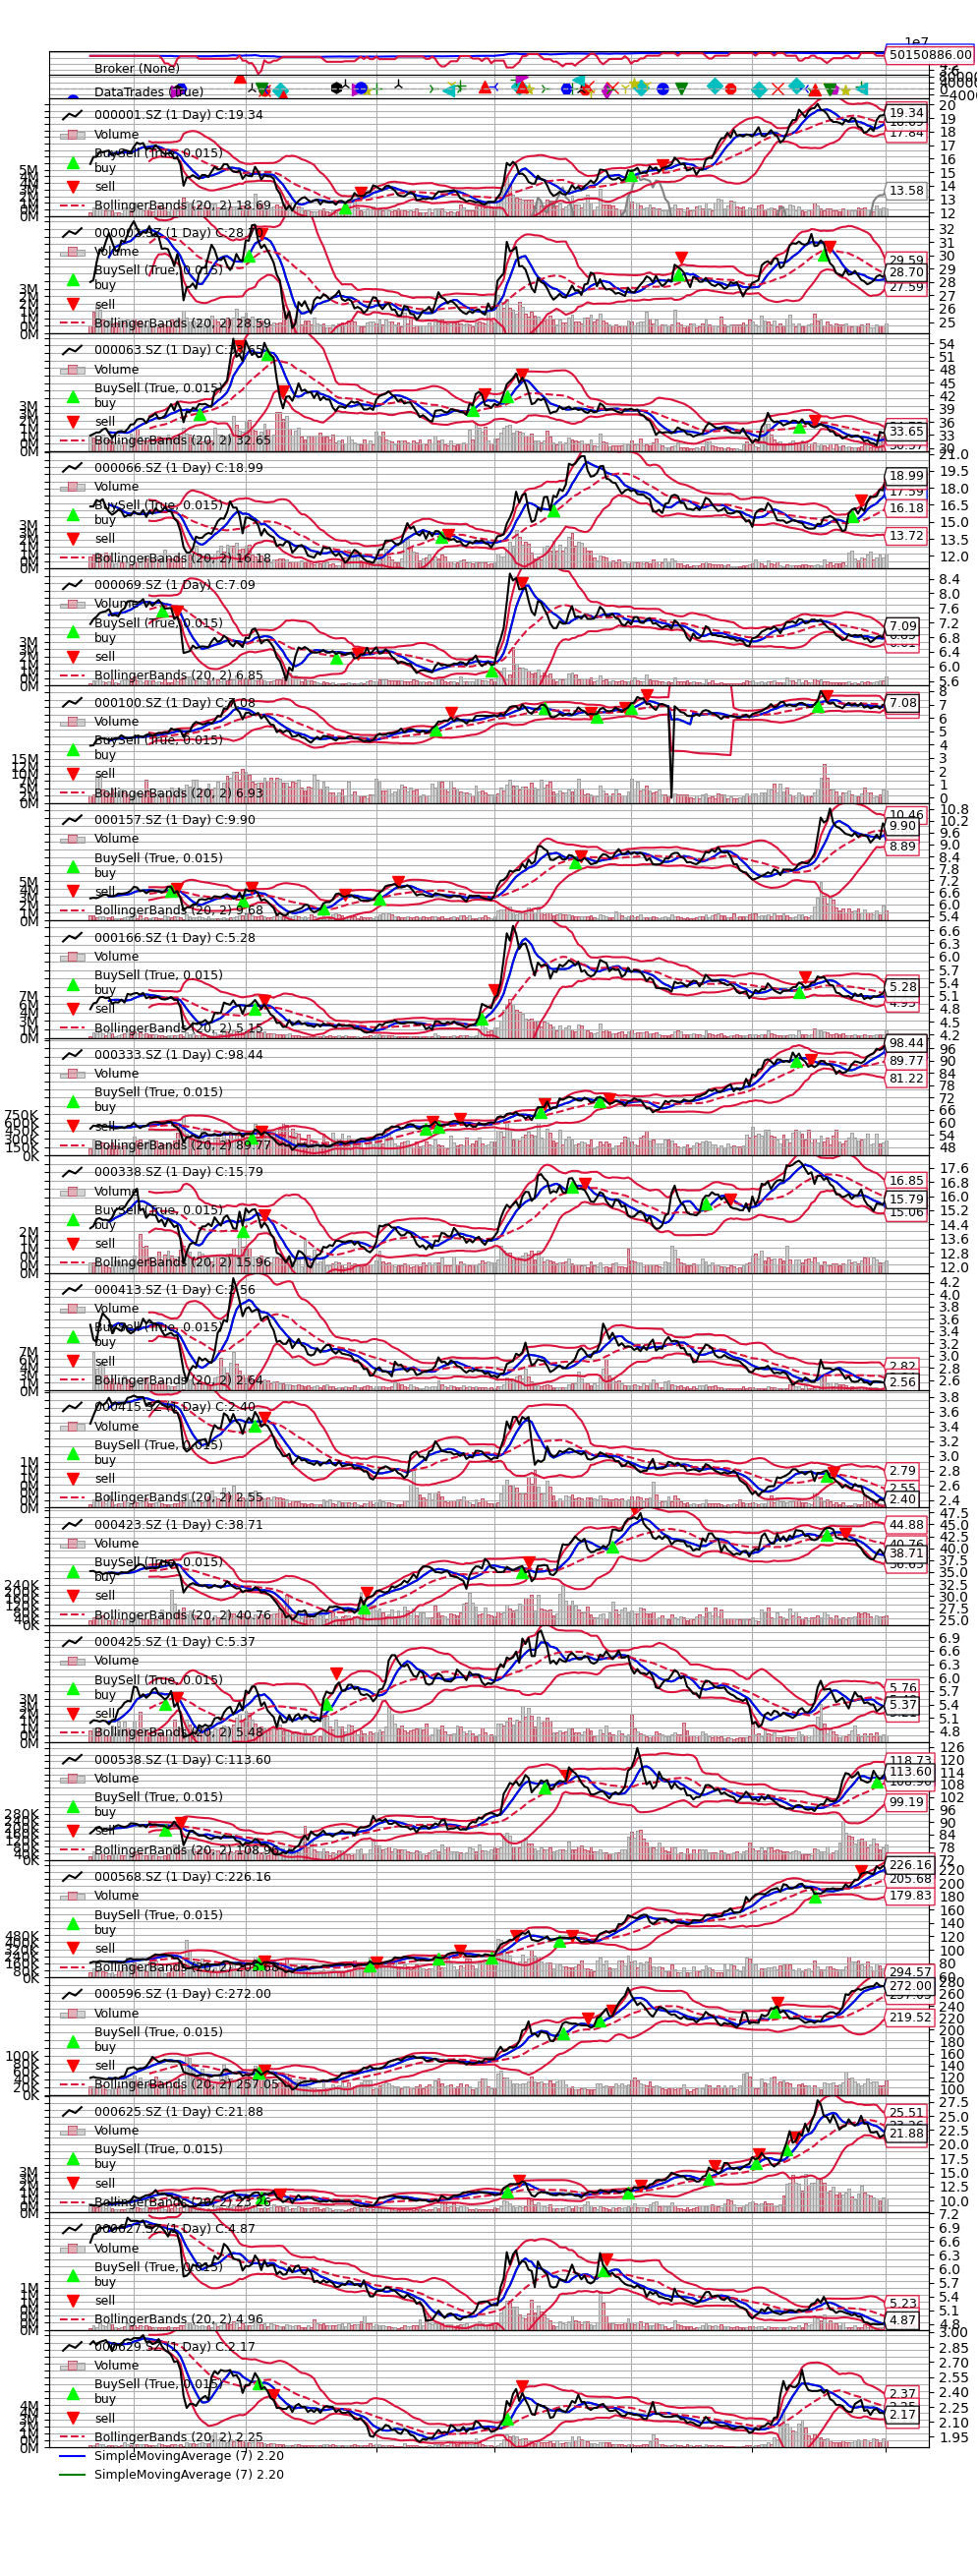

[[<Figure size 640x480 with 42 Axes>]]

In [51]:
cerebro.plot()

### 循环调参

In [ ]:
profit_dict = {}

# 904ff4752522814dca00e032a709fdfc26d8744913500ef204e02157
# 74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6

date_idx = pd.read_csv('.\\Data\\2019\\000001.SZ.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).trade_date

def getdata_mul(s_code, start=datetime.date(2020, 12, 31)-datetime.timedelta(days = 385),
                end = datetime.date(2020, 12, 31)):
    global cerebro, date_idx
    df = pd.read_csv('.\\Data\\2019\\'+s_code+'.csv', 
                     converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    df_new = pd.DataFrame([[x,0,0,0,0,0,0] for x in date_idx if x not in df.index], columns=['trade_date', 'open', 'high', 'low', 'close', 'volume', 'openinterest'])
    df_new.set_index('trade_date', inplace=True)
    if len(df_new) != 0:
        df = pd.concat([df_new, df])
    df.sort_index(inplace=True)
    data = bt.feeds.PandasData(dataname=df, fromdate=s_date, todate=e_date)
    cerebro.adddata(data, name=s_code)
    return

s_date = datetime.date(2020, 12, 31) - datetime.timedelta(days = 385)
e_date = datetime.date(2020, 12, 31)


stock_index = '399300.SZ'
pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=stock_index,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()


if __name__ == '__main__':
    for i in range(3,10):
        for j in range(3,10):
            profit = list()
            for _ in range(10):
                random.seed(10086)
                # Create a cerebro entity
                cerebro = bt.Cerebro(tradehistory=True)

                # Add a strategy
                strats = cerebro.addstrategy(BW_comp, printlog=False, units=len(index_list), wave_period_buy=i, wave_period_sell=j)
                t_list = [utilsJ.MyThread(getdata_mul, (s_code, s_date, e_date)) for s_code in index_list]
                [t.start() for t in t_list]
                [t.join() for t in t_list]
                #for s_code in index_list:
                #    df = pd.read_csv('.\\Data\\2020\\'+s_code+'.csv',
                #                     converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
                #    data = bt.feeds.PandasData(dataname=df, fromdate=s_date, todate=e_date)

                    # Add the index Data Feed to Cerebo
                #    cerebro.adddata(data, name=s_code)
                
                # Set cash inside the strategy
                cerebro.broker = bt.brokers.BackBroker(coc=True)
                cerebro.broker.setcash(5000 * len(index_list) * 100)

                # Set commission
                #cerebro.broker.setcommission()

                # Print out the starting conditions
                start_value = cerebro.broker.getvalue()
                #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

                # Run over everything
                cerebro.run(maxcpus=16)

                # Print out the final result
                final_value = cerebro.broker.getvalue()
                #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
                #print('(%s, %s) Net Profit: %.2f%%' % (s[0], s[1], (final_value-start_value)/start_value*100))
                profit.append((final_value - start_value) / start_value * 100)
            print((i, j, max(profit), min(profit), np.mean(profit)))